### ProjF3 - Baseline Model

Use this document as a template to provide the evaluation of your baseline model. You are welcome to go in as much depth as needed.

Make sure you keep the sections specified in this template, but you are welcome to add more cells with your code or explanation as needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import Counter
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import string
import random
import pickle
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
import re
import warnings
warnings.filterwarnings('ignore')
random.seed(100)
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from numpy import array

from tensorflow import keras


from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, Embedding, Dropout, add, LSTM
from keras.callbacks import ModelCheckpoint
from pickle import load

from numpy import argmax
from pickle import load
from keras.models import load_model
from pickle import dump
import pickle

### Load and Prepare Data

This should illustrate your code for loading the dataset and the split into training, validation and testing. You can add steps like pre-processing if needed.

Load the dataset that was split into train/val/test

In [5]:
### YOUR CODE HERE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df_train_dataset = pd.read_csv('/content/drive/MyDrive/image_caption_train_data.csv')
df_val_dataset = pd.read_csv('/content/drive/MyDrive/image_caption_val_data.csv')
df_test_dataset = pd.read_csv('/content/drive/MyDrive/image_caption_test_data.csv')

In [7]:
print(len(df_train_dataset['filename'].unique()))
print(len(df_val_dataset['filename'].unique()))
print(len(df_test_dataset['filename'].unique()))

6472
809
810


In [8]:
df_train_dataset['filename'] = df_train_dataset['filename'].str.replace('.jpg', '', regex=False)
df_val_dataset['filename'] = df_val_dataset['filename'].str.replace('.jpg', '', regex=False)
df_test_dataset['filename'] = df_test_dataset['filename'].str.replace('.jpg', '', regex=False)

In [9]:
df_train_dataset.head()

,index,filename,caption
0,0,1000268201_693b08cb0e,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e,a girl going into a wooden building .
2,2,1000268201_693b08cb0e,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e,a little girl in a pink dress going into a woo...


In [10]:
# get unique file names from train and val
unique_train_filenames = df_train_dataset['filename'].unique()
unique_val_filenames = df_val_dataset['filename'].unique()

In [11]:
print(len(unique_train_filenames))
print(len(unique_val_filenames))

6472
809


In [12]:
def randomly_remove_items_df(dataframe, unique_values, num_items_to_remove):
    # Get keys from the dictionary
    df = dataframe.copy()

    # Get keys (unique values) from the column
    keys_to_remove = random.sample(list(unique_values), num_items_to_remove)

    # Remove rows from the DataFrame based on the keys_to_remove
    df = df[~df['filename'].isin(keys_to_remove)]

    return keys_to_remove, df

In [13]:
# reduce the number of sample from the dataframe to for the batches while training
train_keys, reduced_train_df = randomly_remove_items_df(df_train_dataset, unique_train_filenames, 8)
val_keys, reduced_val_df = randomly_remove_items_df(df_val_dataset, unique_val_filenames, 41)

In [14]:
print(len(train_keys))
print(len(reduced_train_df['filename'].unique()))
print(len(val_keys))
print(len(reduced_val_df['filename'].unique()))

8
6464
41
768


# Text(Caption) Preprocessing Methods
1. Remove punctuation
2. Remove multiple spaces
3. Convert all words to lowercase
4. Remove numerical characters
5. Remove single character words
6. Lemmatize the tokens

In [15]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
# function that removes punctuation in the sentences
def remove_punctuation(text_original):
    text_without_punct = ''.join([char for char in text_original if char not in string.punctuation])
    return text_without_punct

# convert all words into lowercase
def convert_to_lowercase(text):
    return text.lower()

# function to remove multiple
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# create word_tokens
def word_tokens(text):
    return word_tokenize(text)

# function that removes numerical values
def remove_numeric(tokens):
    return [word for word in tokens if word.isalpha()]

# function that removes single character
def removing_single_char(tokens):
    return [word for word in tokens if len(word) > 1]

# lemmatize the text
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in tokens])

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = convert_to_lowercase(text)
    text = remove_multiple_spaces(text)
    tokens = word_tokens(text)
    tokens = remove_numeric(tokens)
    tokens = removing_single_char(tokens)
    text = lemmatize_text(tokens)
    return text

In [17]:
# mapping the images to captions by creating a dictionary where keys are the image titles and values are list of captions
def image_caption_mapping(dataframe):
    img_caption_map = {}

    for index, row in dataframe.iterrows():
        caption = row['caption']
        image_name = row['filename']

        if image_name in img_caption_map:
            img_caption_map[image_name].append('startseq ' + text_clean(caption) + ' endseq')
        else:
            img_caption_map[image_name] = ['startseq ' + text_clean(caption) + ' endseq']

    return img_caption_map


In [18]:
# get the mapping of filenames and cleaned captions
train_img_caption_clean = image_caption_mapping(reduced_train_df)
val_img_caption_clean = image_caption_mapping(reduced_val_df)

In [19]:
reduced_train_df.head()

,index,filename,caption
0,0,1000268201_693b08cb0e,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e,a girl going into a wooden building .
2,2,1000268201_693b08cb0e,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e,a little girl in a pink dress going into a woo...


In [20]:
all_words = []
for caption in reduced_train_df['caption']:
    words = word_tokenize(caption)
    all_words.extend(words)

unique_words = set(all_words)
print(len(unique_words))

8094


In [21]:
def get_all_captions(datamap):
    all_captions = []
    for key, values in datamap.items():
        for caption in values:
            all_captions.append(caption)
    return all_captions

In [22]:
all_train_captions = get_all_captions(train_img_caption_clean)

In [23]:
print(all_train_captions[:5])

['startseq child in pink dress is climbing up set of stair in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stair to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [24]:
# tokenize the train dataset captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_train_captions)
vocab_size = len(tokenizer.word_index) + 1

In [25]:
max_length = max(len(caption.split()) for caption in all_train_captions)

In [26]:
print(max_length)
print(vocab_size)

34
6866


In [27]:
with open('/content/drive/MyDrive/train_image_features_vgg16.pkl', 'rb') as f:
    train_image_features = pickle.load(f)

train_image_features = {key.replace('.jpg', ''): value for key, value in train_image_features.items()}

In [28]:
with open('/content/drive/MyDrive/val_image_features_vgg16.pkl', 'rb') as f:
    val_image_features = pickle.load(f)

val_image_features = {key.replace('.jpg', ''): value for key, value in val_image_features.items()}

In [29]:
print(len(train_image_features))
print(len(val_image_features))

6472
809


In [30]:
# Remove key-value pairs from train features dictionary
for key in train_keys:
    del train_image_features[key]

In [31]:
# Remove key-value pairs from val features dictionary
for key in val_keys:
    del val_image_features[key]

In [32]:
print(len(train_image_features))
print(len(val_image_features))

6464
768


In [33]:
print(max_length)
print(vocab_size)

34
6866


In [34]:
# Define the meta data
meta_data = {
    'max_length': max_length,
    'vocab_size': vocab_size
}

# Save the tokenizer and meta data to a file
with open('/content/drive/MyDrive/tokenizer_meta.pkl', 'wb') as f:
    pickle.dump({'tokenizer': tokenizer, 'meta_data': meta_data}, f)

### 2. Prepare your Baseline Model

Here you can have your code to either train (e.g., if you are building it from scratch) or load (e.g., in the case that you are loading a pre-trained model) your model. These steps may require you to use other packages or python files. You can just call them here. You don't have to include them in your submission. Remember that we will be looking at the saved outputs in the notebooked and we will not run the entire notebook.

In [35]:
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from keras.models import Model
from keras.utils import plot_model
from keras.metrics import categorical_accuracy

def define_model(vocab_size, max_length):
    # feature extractor model
    inputs_1 = Input(shape=(4096,))
    fe_1 = Dropout(0.5)(inputs_1)
    fe_2 = Dense(256, activation='relu')(fe_1)

    # sequence model
    inputs_2 = Input(shape=(max_length,))
    se_1 = Embedding(vocab_size, 256, mask_zero=True)(inputs_2)
    se_2 = Dropout(0.5)(se_1)
    se_3 = LSTM(256)(se_2)

    # decoder model
    # print(fe_2.shape)
    # print(se_3.shape)
    decoder_1 = add([fe_2, se_3])
    decoder_2 = Dense(256, activation='relu')(decoder_1)
    outputs = Dense(vocab_size, activation='softmax')(decoder_2)

    # tie it together [image, sequence] [word]
    model = Model(inputs=[inputs_1, inputs_2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    return model

In [36]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator(image_features_data, caption_features_data, tokenizer, max_len, vocab_len, batch_size):
    image_keys = list(image_features_data.keys())
    while True:
        np.random.shuffle(image_keys)
        batches = len(image_keys) // batch_size

        for batch_idx in range(batches):
            start_idx = batch_idx * batch_size
            end_idx = (batch_idx + 1) * batch_size
            batch_keys = image_keys[start_idx:end_idx]

            x1, x2, y = [], [], []

            for image_key in batch_keys:
                img_features = image_features_data[image_key][0]
                captions = caption_features_data[image_key]

                for caption in captions:
                    seq = tokenizer.texts_to_sequences([caption])[0]

                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]

                        in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                        out_seq = to_categorical([out_seq], num_classes=vocab_len)[0]

                        x1.append(img_features)
                        x2.append(in_seq)
                        y.append(out_seq)

                        if len(x1) == batch_size:
                            yield ((np.array(x1), np.array(x2)), np.array(y))
                            x1, x2, y = [], [], []
#         # Yield the remaining examples if they don't make a full batch
#         if len(x1) > 0:
#             yield (np.array(x1), np.array(x2)), np.array(y)

In [37]:
train_data = data_generator(train_image_features, train_img_caption_clean, tokenizer, max_length, vocab_size, 64)
val_data = data_generator(val_image_features, val_img_caption_clean, tokenizer, max_length, vocab_size, 64)

In [38]:
baseline_model = define_model(vocab_size, max_length)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              1757696   ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_1[0][0]']             
                                                                                              

In [39]:
# define checkpoint callback
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = './baselinemodel3-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.keras'
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_loss')
callbacks = [model_checkpoint]

steps_per_epoch = (len(train_image_features) * 5) // 64
validation_steps = (len(val_image_features) * 5) // 64

In [40]:
history = baseline_model.fit(train_data, epochs = 20, callbacks = callbacks, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
505/505 [==============================] - 67s 113ms/step - loss: 5.6928 - val_loss: 5.3486
Epoch 2/20
505/505 [==============================] - 52s 103ms/step - loss: 4.9699 - val_loss: 4.6829
Epoch 3/20
505/505 [==============================] - 51s 100ms/step - loss: 4.6546 - val_loss: 4.4804
Epoch 4/20
505/505 [==============================] - 52s 102ms/step - loss: 4.5290 - val_loss: 4.4182
Epoch 5/20
505/505 [==============================] - 49s 98ms/step - loss: 4.4155 - val_loss: 4.1501
Epoch 6/20
505/505 [==============================] - 51s 102ms/step - loss: 4.3202 - val_loss: 3.9967
Epoch 7/20
505/505 [==============================] - 53s 106ms/step - loss: 4.2388 - val_loss: 4.0841
Epoch 8/20
505/505 [==============================] - 53s 105ms/step - loss: 4.1521 - val_loss: 4.0620
Epoch 9/20
505/505 [==============================] - 53s 104ms/step - loss: 4.1153 - val_loss: 4.1228
Epoch 10/20
505/505 [==============================] - 50s 99ms/step - los

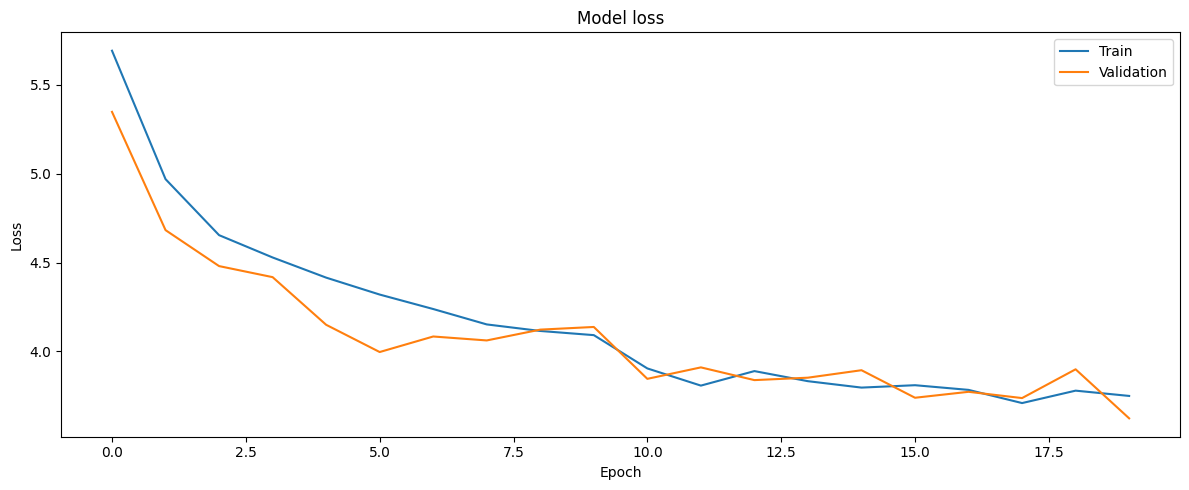

In [41]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

### 3. Baseline Performance

Make sure to include the following:
- Performance on the training set
- Performance on the test set
- Provide some screenshots of your output (e.g., pictures, text output, or a histogram of predicted values in the case of tabular data). Any visualization of the predictions are welcome.

In [42]:
# loading test dataset
unique_test_filenames = df_test_dataset['filename'].unique()
test_keys, reduced_test_df = randomly_remove_items_df(df_test_dataset, unique_test_filenames, 42)
test_img_caption_clean = image_caption_mapping(reduced_test_df)

with open('/content/drive/MyDrive/test_image_features_vgg16.pkl', 'rb') as f:
    test_image_features = pickle.load(f)

test_image_features = {key.replace('.jpg', ''): value for key, value in test_image_features.items()}

# Remove key-value pairs from test features dictionary
for key in test_keys:
    del test_image_features[key]

In [ ]:
np.expand_dims(test_image_features['2714703706_d21c5cb8df'][0], axis=0).shape

(1, 4096)

In [43]:
print(len(test_image_features))
print(len(test_img_caption_clean))

768
768


In [44]:
best_model = load_model('/content/drive/MyDrive/baselinemodel3-ep20-loss3.750-val_loss3.623.keras')

In [45]:
test_data = data_generator(test_image_features, test_img_caption_clean, tokenizer, max_length, vocab_size, 64)
test_steps = (len(test_image_features) * 5) // 64
results = best_model.evaluate(test_data, steps=test_steps)

60/60 [==============================] - 3s 15ms/step - loss: 3.6560


In [46]:
results

3.6559574604034424

In [47]:
def generate_caption(image_features, model, tokenizer, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image_features, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [48]:
from nltk.translate.bleu_score import corpus_bleu
actual = []
predicted = []

for key in test_image_features.keys():
    image = test_image_features[key][0]
    image = np.expand_dims(image, axis=0)
    reference_captions = test_img_caption_clean[key]
    generated_caption = generate_caption(image, best_model, tokenizer, max_length).split()

    actual.append([caption.split() for caption in reference_captions])
    predicted.append(generated_caption)

# Calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.481673
BLEU-2: 0.253430
BLEU-3: 0.171905
BLEU-4: 0.077139


In [49]:
image_model = VGG16()

553467096/553467096 [==============================] - 14s 0us/step


In [50]:
# extract features from each photo in the directory
def extract_features(filename, model):
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [51]:
def predict_caption(filename, model):
    with open('tokenizer_meta.pkl', 'rb') as f:
        tokenizer_meta_data = pickle.load(f)

    tokenizer = tokenizer_meta_data['tokenizer']
    vocab_size = tokenizer_meta_data['meta_data']['vocab_size']
    max_len = tokenizer_meta_data['meta_data']['max_length']

    caption_model = load_model('/content/drive/MyDrive/baselinemodel3-ep20-loss3.750-val_loss3.623.keras')
    image_features = extract_features(filename, model)
    description = generate_caption(image_features, caption_model, tokenizer, max_length)
    text = description.split()[1:-1]
    print(text)
    return " ".join(text)


In [ ]:
predicted_caption = predict_caption('dogs_image.jpg', image_model)

['black', 'dog', 'is', 'running', 'through', 'the', 'grass']


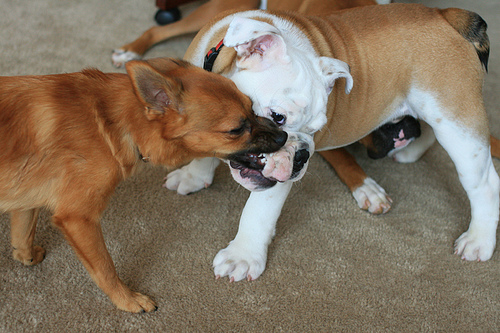

Actual Captions:
[['startseq', 'dog', 'playing', 'endseq'], ['startseq', 'brown', 'dog', 'is', 'biting', 'white', 'and', 'tan', 'dog', 'on', 'the', 'snout', 'endseq'], ['startseq', 'the', 'brown', 'dog', 'ha', 'hold', 'of', 'the', 'other', 'dog', 'cheek', 'with', 'it', 'teeth', 'endseq'], ['startseq', 'two', 'dog', 'are', 'nuzzling', 'each', 'other', 'nose', 'to', 'nose', 'endseq'], ['startseq', 'two', 'dog', 'bite', 'at', 'each', 'other', 'on', 'the', 'carpet', 'endseq']]
[['startseq', 'man', 'is', 'heading', 'out', 'to', 'see', 'with', 'his', 'surfboard', 'in', 'hand', 'endseq'], ['startseq', 'man', 'with', 'white', 'surfboard', 'is', 'walking', 'into', 'the', 'water', 'endseq'], ['startseq', 'person', 'walk', 'into', 'the', 'water', 'carrying', 'white', 'surfboard', 'endseq'], ['startseq', 'surfer', 'walking', 'into', 'the', 'ocean', 'endseq'], ['startseq', 'surfer', 'with', 'board', 'march', 'out', 'to', 'sea', 'on', 'gray', 'day', 'endseq']]
[['startseq', 'arabian', 'dressed', 'la

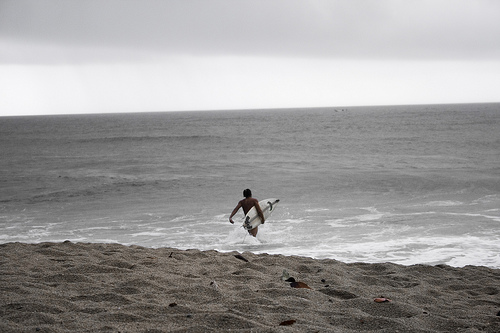

Actual Captions:
[['startseq', 'man', 'is', 'heading', 'out', 'to', 'see', 'with', 'his', 'surfboard', 'in', 'hand', 'endseq'], ['startseq', 'man', 'with', 'white', 'surfboard', 'is', 'walking', 'into', 'the', 'water', 'endseq'], ['startseq', 'person', 'walk', 'into', 'the', 'water', 'carrying', 'white', 'surfboard', 'endseq'], ['startseq', 'surfer', 'walking', 'into', 'the', 'ocean', 'endseq'], ['startseq', 'surfer', 'with', 'board', 'march', 'out', 'to', 'sea', 'on', 'gray', 'day', 'endseq']]
[['startseq', 'arabian', 'dressed', 'lady', 'lean', 'backwards', 'holding', 'skinny', 'crooked', 'sword', 'endseq'], ['startseq', 'costumed', 'woman', 'with', 'sword', 'doe', 'backbend', 'endseq'], ['startseq', 'woman', 'bending', 'over', 'backwards', 'endseq'], ['startseq', 'woman', 'in', 'belly', 'dancing', 'outfit', 'bending', 'over', 'backwards', 'endseq'], ['startseq', 'woman', 'in', 'dance', 'costume', 'is', 'bending', 'over', 'backward', 'and', 'holding', 'sword', 'endseq']]
[['startseq',

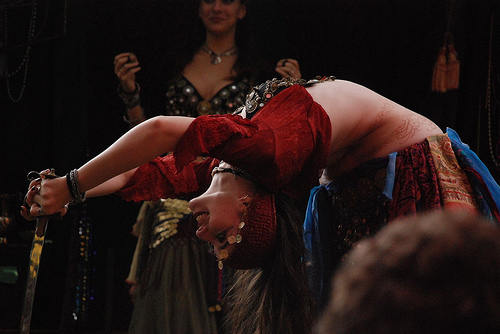

Actual Captions:
[['startseq', 'arabian', 'dressed', 'lady', 'lean', 'backwards', 'holding', 'skinny', 'crooked', 'sword', 'endseq'], ['startseq', 'costumed', 'woman', 'with', 'sword', 'doe', 'backbend', 'endseq'], ['startseq', 'woman', 'bending', 'over', 'backwards', 'endseq'], ['startseq', 'woman', 'in', 'belly', 'dancing', 'outfit', 'bending', 'over', 'backwards', 'endseq'], ['startseq', 'woman', 'in', 'dance', 'costume', 'is', 'bending', 'over', 'backward', 'and', 'holding', 'sword', 'endseq']]
[['startseq', 'woman', 'and', 'young', 'girl', 'pose', 'and', 'smile', 'for', 'photo', 'endseq'], ['startseq', 'woman', 'and', 'young', 'girl', 'smiling', 'for', 'the', 'camera', 'in', 'front', 'of', 'some', 'flower', 'endseq'], ['startseq', 'woman', 'and', 'girl', 'pose', 'together', 'in', 'garden', 'endseq'], ['startseq', 'woman', 'pose', 'with', 'small', 'girl', 'on', 'her', 'lap', 'in', 'front', 'of', 'flower', 'bush', 'endseq'], ['startseq', 'woman', 'with', 'brown', 'hair', 'is', 'sitt

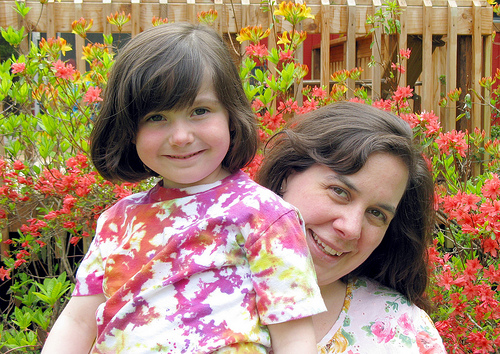

Actual Captions:
[['startseq', 'woman', 'and', 'young', 'girl', 'pose', 'and', 'smile', 'for', 'photo', 'endseq'], ['startseq', 'woman', 'and', 'young', 'girl', 'smiling', 'for', 'the', 'camera', 'in', 'front', 'of', 'some', 'flower', 'endseq'], ['startseq', 'woman', 'and', 'girl', 'pose', 'together', 'in', 'garden', 'endseq'], ['startseq', 'woman', 'pose', 'with', 'small', 'girl', 'on', 'her', 'lap', 'in', 'front', 'of', 'flower', 'bush', 'endseq'], ['startseq', 'woman', 'with', 'brown', 'hair', 'is', 'sitting', 'with', 'little', 'girl', 'with', 'short', 'brown', 'hair', 'outside', 'next', 'to', 'some', 'red', 'flower', 'endseq']]
[['startseq', 'brown', 'dog', 'is', 'leaping', 'over', 'fallen', 'tree', 'in', 'the', 'wood', 'endseq'], ['startseq', 'brown', 'dog', 'with', 'tongue', 'sticking', 'out', 'jumping', 'over', 'log', 'endseq'], ['startseq', 'dog', 'is', 'jumping', 'over', 'log', 'with', 'ear', 'flying', 'and', 'tongue', 'out', 'endseq'], ['startseq', 'dog', 'leap', 'over', 'log

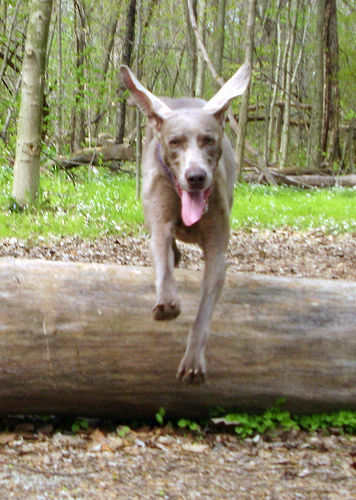

Actual Captions:
[['startseq', 'brown', 'dog', 'is', 'leaping', 'over', 'fallen', 'tree', 'in', 'the', 'wood', 'endseq'], ['startseq', 'brown', 'dog', 'with', 'tongue', 'sticking', 'out', 'jumping', 'over', 'log', 'endseq'], ['startseq', 'dog', 'is', 'jumping', 'over', 'log', 'with', 'ear', 'flying', 'and', 'tongue', 'out', 'endseq'], ['startseq', 'dog', 'leap', 'over', 'log', 'in', 'the', 'wood', 'endseq'], ['startseq', 'the', 'dog', 'with', 'big', 'ear', 'is', 'leaping', 'over', 'fallen', 'tree', 'endseq']]
[['startseq', 'boy', 'is', 'riding', 'scooter', 'down', 'the', 'concrete', 'path', 'endseq'], ['startseq', 'child', 'on', 'scooter', 'moving', 'down', 'the', 'sidewalk', 'endseq'], ['startseq', 'youth', 'ride', 'scooter', 'on', 'sidewalk', 'near', 'building', 'endseq'], ['startseq', 'the', 'boy', 'is', 'riding', 'his', 'scooter', 'on', 'the', 'sidewalk', 'endseq'], ['startseq', 'young', 'boy', 'ride', 'his', 'scooter', 'on', 'drive', 'endseq']]
[['startseq', 'vendor', 'in', 'all',

In [56]:
from IPython.display import display
from PIL import Image

def display_images_with_captions(image_features, actual_captions, predicted_captions, num_images=5):
    image_keys = list(image_features.keys())[:num_images]

    for i in range(len(image_keys)):
        # Load and display the image
        image_path = '/content/drive/MyDrive/Flicker8k_Dataset/' + image_keys[i] + '.jpg'  # Assuming images are in this directory
        image = Image.open(image_path)
        display(image)

        # Print actual and predicted captions
        print("Actual Captions:")
        for caption in actual_captions[i:i+5]:
            print(caption)

        print("\nPredicted Caption:")
        for caption in predicted_captions[i:i+5]:
            print(caption)
        print("-" * 50)

# Assuming 'test_image_features', 'test_actual_captions', and 'test_predicted_captions' are available
display_images_with_captions(test_image_features, actual, predicted)